In [3]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw12.ok')

Assignment: Homework 12: Classification
OK, version v1.12.5



# Homework 12: Classification

**Reading**: 

* [Classification](https://www.inferentialthinking.com/chapters/17/classification.html)


Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

Homework 12 is due **Thursday, 4/30 at 11:59pm**. You will receive an early submission bonus point if you turn in your final submission by Wednesday, 4/29 at 11:59pm. Start early so that you can come to office hours if you're stuck. Check the website for the office hours schedule. Late work will not be accepted as per the [policies](http://data8.org/sp20/policies.html) of this course. 

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the policies page to learn more about how to learn cooperatively.

For all problems that you must write out explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook! For example, if you use `max_temperature` in your answer to one question, do not reassign it later on.

In [4]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

from client.api.notebook import Notebook
ok = Notebook('hw12.ok')

Assignment: Homework 12: Classification
OK, version v1.12.5



## 1. Bay Area School Coordinates with Classification


Welcome to Homework 12! This homework is about k-Nearest Neighbors classification (kNN). Since this topic is covered in depth in Project 3, the purpose of this homework is to reinforce the basics of this method. You can and should reuse a lot of code that you wrote for Project 3 for this homework, or use code from this homework on Project 3!

## Our Dearest Neighbors

Carol is trying classify students as either attendees of UC Berkeley or as attendees of Leland Stanford Junior College. To classify the students, Carol has access to the coordinates of the location they live during the school year. First, load in the `coordinates` table.

In [5]:
# Just run this cell!
coordinates = Table.read_table('coordinates.csv')
coordinates.show(5)

latitude,longitude,school
37.8693,-122.255,Berkeley
37.8651,-122.256,Berkeley
37.8661,-122.254,Berkeley
37.868,-122.26,Berkeley
37.8683,-122.257,Berkeley


As usual, let's investigate our data visually before performing any kind of numerical analysis.

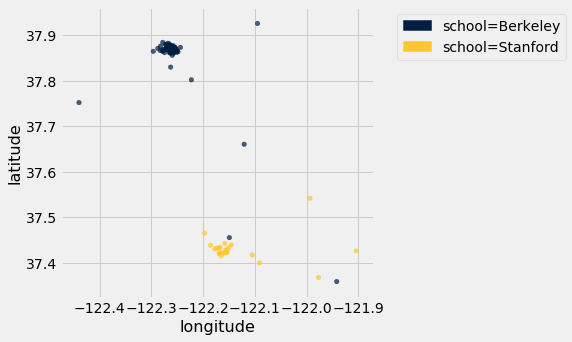

In [6]:
# Just run this cell!
coordinates.scatter("longitude", "latitude", group="school")

The locations of the points on this scatter plot might be familiar - run the following cell to see what they correspond to.

In [7]:
# Just run this cell!
colors = {"Berkeley":"blue", "Stanford":"red"}
t = Table().with_columns("lat", coordinates.column(0), 
                                      "lon", coordinates.column(1), 
                                      "color", coordinates.apply(colors.get, 2)
                        )
Circle.map_table(t, radius=5, fill_opacity=1)

#### Question 1

Let's begin implementing the k-Nearest Neighbors algorithm. Define the `distance` function, which takes in two arguments: an array of numerical features, and a different array of numerical features. The function should return the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two arrays. Euclidean distance is often referred to as the straight-line distance formula that you may have learned previously.


<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

In [8]:
def distance(arr1, arr2):
    return np.sqrt(sum((arr1 - arr2)**2))

# Don't change/delete the code below in this cell
distance_example = distance(make_array(1, 2, 3), make_array(4, 5, 6))
distance_example

5.196152422706632

In [9]:
ok.grade("q1_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Splitting the dataset
We'll do 2 different kinds of things with the `coordinates` dataset:
1. We'll build a classifier using coordinates for which we know the associated label; this will teach it to recognize labels of similar coordinate values. This process is known as *training*.
2. We'll evaluate or *test* the accuracy of the classifier we build on data we haven't seen before.

For reasons discussed in lecture and the textbook, we want to use separate datasets for these two purposes.  So we split up our one dataset into two.

#### Question 2

Next, let's split our dataset into a training set and a test set. Since `coordinates` has $100$ rows, let's create a training set with the first 75 rows and a test set with the remaining 25 rows. Remember that assignment to each group should be random, so we should shuffle the table first.

*Hint: as a first step we can shuffle all the rows, then use the* `tbl.take` *function to split up the rows for each table*


<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

In [10]:
shuffled_table = coordinates.sample(with_replacement=False)
train = shuffled_table.take(np.arange(75))
test = shuffled_table.take(np.arange(75, 100, 1))

print("Training set:\t",   train.num_rows, "examples")
print("Test set:\t",       test.num_rows, "examples")
train.show(5), test.show(5);

Training set:	 75 examples
Test set:	 25 examples


latitude,longitude,school
37.5416,-121.994,Stanford
37.8676,-122.258,Berkeley
37.8805,-122.273,Berkeley
37.8677,-122.25,Berkeley
37.8689,-122.255,Berkeley


latitude,longitude,school
37.8772,-122.265,Berkeley
37.8651,-122.256,Berkeley
37.8663,-122.257,Berkeley
37.8688,-122.255,Berkeley
37.4276,-122.157,Stanford


In [11]:
ok.grade("q1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3

Assign `features` to an array of the labels of the features from the `coordinates` table.

*Hint: which of the column labels in the `coordinates` table are the features, and which of the column labels correspond to the class we're trying to predict?*

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

In [12]:
features = make_array('latitude', 'longitude')
features

array(['latitude', 'longitude'], dtype='<U9')

In [13]:
ok.grade("q1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<div class="hide">\pagebreak</div>

#### Question 4

Now define the `classify` function. This function should take in a `row` from a table like `test` and classify it based on the data in `train` using the `k`-Nearest Neighbors based on the correct `features`.

*Hint: use the `row_to_array` function we defined for you to convert rows to arrays of features so that you can use the `distance` function you defined earlier.*

*Hint 2: the skeleton code we provided iterates through each row in the training set*

<!--
BEGIN QUESTION
name: q1_4
manual: false
-->

In [14]:
def row_to_array(row, features):
    arr = make_array()
    for feature in features:
        arr = np.append(arr, row.item(feature))
    return arr

def classify(row, k, train):
    test_row_features_array = row_to_array(row, features)
    distances = make_array()
    for train_row in train.rows:
        train_row_features_array = row_to_array(train_row, features)
        row_distance = distance(train_row_features_array, test_row_features_array)
        distances = np.append(distances, row_distance)
    train_with_distances = train.with_column('distance', distances)
    nearest_neighbors = train_with_distances.sort('distance', descending=False).take(np.arange(k))
    most_common_label = nearest_neighbors.group('school').column(0).item(0)
    return most_common_label

# Don't modify/delete the code below
first_test = classify(test.row(0), 5, train)
first_test

'Berkeley'

In [15]:
ok.grade("q1_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<div class="hide">\pagebreak</div>

#### Question 5

Define the function `three_classify` that takes a `row` from `test` as an argument and classifies the row based on using 3-Nearest Neighbors. Use this function to find the `accuracy` of a 3-NN classifier on the `test` set. `accuracy` should be a proportion (not a percentage) of the schools that were correctly predicted.

*Hint: you should be using a function you just created!*

*Note: Usually before using a classifier on a test set, we'd classify first on a "validation" set, which we then can modify our training set again if need be, before actually testing on the test set. You don’t need to do that for this question, but you will learn about this more in Data 100.*

<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

In [16]:
def three_classify(row):
    return classify(row, 3, train)

test_with_prediction = test.with_column("prediction", test.apply(three_classify))
labels_correct = np.count_nonzero(test_with_prediction.column('school') == test_with_prediction.column('prediction'))
accuracy = labels_correct / test_with_prediction.num_rows
accuracy

1.0

In [17]:
ok.grade("q1_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 6

There are 77 rows of Berkeley students and 23 rows of Stanford students in the `coordinates` table. If we used the entire `coordinates` table as the train set, what is the smallest value of k that would ensure that a k-Nearest Neighbor classifier would always predict Berkeley as the class? Assign the value to `k`.

<!--
BEGIN QUESTION
name: q1_6
manual: false
-->

In [18]:
k = 47
k

47

In [19]:
ok.grade("q1_6");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 7

Why do we divide our data into a training and test set? Should we use our test set to find the best possible number of neighbors for a k-NN classifer? What is the point of a test set, and why do we only want to use the test set once? Explain. 


<!--
BEGIN QUESTION
name: q1_7
manual: true
-->
<!-- EXPORT TO PDF -->

This is because our training set and our test set have different purposes. The test set is a set on which we try out our classifier and see what fraction of times it classifies correctly. The training set is a set on which we can do any amount of exploration to build our classifier. So no, we should not use our test set to find the best possible number of neighbors for a k-NN classifer, and we should use our training set instead because we already know the labels for the training set so we can measure the distance between new points and known points to get nearest neighbors, but for the test set, we do not know their labels.

#### Question 8

Why do we use an odd-numbered `k` in k-NN? Explain.


<!--
BEGIN QUESTION
name: q1_8
manual: true
-->
<!-- EXPORT TO PDF -->

We use an odd-numbered k in k-NN because if there is an even k, then it could be that k/2 of the rows corresponded to label 1, and k/2 of the rows corresponded to label 2, so we wouldn't be able to effectively classify the data based on the information. E.g., if we used 4 nearest neighbors in our example, it could be that 2 of the 4 rows suggest Stanford, while the other 2 suggest Berkeley. So we take an odd-numbered k, so that this situation does not arise and one label is clearly favored over the other. 

#### Question 9

Thomas has devised a scheme for splitting up the test and training set. For each row from `coordinates`:

- Rows for Stanford students have a 50% chance of being placed in the train set and 50% chance of placed in the test set.

- Rows for Berkeley students have a 80% chance of being placed in the train set and 20% chance of placed in the test set.


Given that a row is in the test set, what is the probability that it corresponds to a Stanford student? Assign that probability to `prob_furd`.

*Hint: Remember that there are 77 Berkeley students and 23 Stanford students in `coordinates`*

*Hint 2: Thomas' last name is Bayes*


<!--
BEGIN QUESTION
name: q1_9
manual: false
-->

In [20]:
prob_furd = ((0.5)*(23/100))/((0.5)*(23/100)+(0.2)*(77/100))
prob_furd

0.4275092936802974

In [21]:
ok.grade("q1_9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## (OPTIONAL, NOT IN SCOPE): k-NN for Non-Binary Classification

**THIS IS NOT IN SCOPE/IS OPTIONAL**. There are no autograder tests for this/code for you to write. It just relies on the function `classify` in Question 4.

In this class, we have taught you how to use the kNN algorithm to classify data as one of two classes. However, much of the data you will encounter in the real world will not fall nicely into one of two categories. 

How can we classify data with non-binary classes? It turns out we can still use kNN! That is, we find the distance between a point and all its neighbors, find the nearest neighbors, and take a majority vote among the neighbors to determine this point's class. 

The only difference is that now the neighboring points have more than two possible classes. This does introduce difficulty because now we have no way of guaranteeing that we will not encounter ties between classes. In the case that we do encounter a tie, we can just arbitrarily choose one of the classes.

In fact, you don't even have to modify the code you wrote before at all to enable multi-class classification!

Let's add some more data to our train table, this time for another class of students, students at San Jose Community College (SJCC).

In [22]:
coordinates_multi = coordinates.with_rows([
                              [37.304346, -121.915401, "SJCC"],
                              [37.316275, -121.913879, "SJCC"],
                              [37.409435, -121.951379, "SJCC"],
                              [37.349387, -121.960771, "SJCC"],
                              [37.329083, -121.928479, "SJCC"],
                              [37.313017, -121.866730, "SJCC"],
                              [37.346525, -121.894767, "SJCC"],
                              [37.364157, -121.955717, "SJCC"],
                              [37.383362, -121.925776, "SJCC"],
                              [37.329545, -121.880639, "SJCC"]                             
])

In [23]:
classify(coordinates_multi.row(0), 5, coordinates_multi)

'Berkeley'

In [24]:
classify(coordinates_multi.row(91), 5, coordinates_multi)

'Stanford'

In [25]:
classify(coordinates_multi.row(105), 5, coordinates_multi)

'SJCC'

Our classifier can classify rows as belonging to one of three classes!

Classification is one of the most important fields in statistics, data science, and machine learning. There are thousands of different classification algorithms and modifications of algorithms! There are many that you'll learn if you continue down the path of becoming a data scientist!

## 2. Final-Semester Survey


You can find the end of semester feedback form [here](https://docs.google.com/forms/d/e/1FAIpQLSeVRzkHTsNIrnbIaYCopJViaFDro1HfemS4y79Q_oZPxUcEvg/viewform?usp=sf_link). Please take some time to fill the survey out! Data 8 is still a relatively new class, and your feedback helps the class get better every semester!

As incentive, if 80% of the course fills out this feedback form **and** the official Berkeley Course Evaluations (which will be released sometime in the next couple of weeks) for Data 8, everyone will receive two points of extra credit!

**Question 1.** Fill out the end of semester feedback form linked above. Once you have submitted, a secret word will be displayed. Set `secret_word` to the secret string at the end of the form.

<!--
BEGIN QUESTION
name: q2_1
manual: false
-->

In [26]:
secret_word = 'bayes'

In [27]:
ok.grade("q2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 3. Submission


Once you're finished, select "Save and Checkpoint" in the File menu and then execute the `submit` cell below. The result will contain a link that you can use to check that your assignment has been submitted successfully. If you submit more than once before the deadline, we will only grade your final submission. If you mistakenly submit the wrong one, you can head to [okpy.org](https://okpy.org/) and flag the correct version. To do so, go to the website, click on this assignment, and find the version you would like to have graded. There should be an option to flag that submission for grading!

In [28]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw12.ipynb'.
Submit... 100% complete
Submission successful for user: nameera.faisal@berkeley.edu
URL: https://okpy.org/cal/data8/sp20/hw12/submissions/kroWo5



In [29]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q') and len(q) <= 10]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t